In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
import cv2
%matplotlib inline

In [ ]:
dataset_path = '/content/drive/MyDrive/Rice_Diseases1'
class_names = ['Bacterial Blight Disease', 'Blast Disease', 'Brown Spot Disease', 'False Smut Disease']

In [ ]:
import os
import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import ImageDataGenerator

# Set your input directory
input_path = '/content/drive/MyDrive/Rice_Diseases1'
target_size = (224, 224)


In [ ]:
# Function to load and preprocess images
def load_and_preprocess_images(input_dir):
    images = []
    labels = []

    for class_name in class_names:
        numeral_path = os.path.join(input_dir, class_name, '*.jpg')
        numeral_paths = glob.glob(numeral_path)

        for image_path in numeral_paths:
            binarized_image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Read as 3 channels
            resized_image = cv2.resize(binarized_image, target_size)
            images.append(resized_image)
            labels.append(class_names.index(class_name))

    return np.array(images), np.array(labels)

# Load and preprocess images
images, labels = load_and_preprocess_images(input_path)


In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=2)


In [ ]:
# Create a data generator with data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)


In [ ]:
# Load the VGG16 model with pre-trained weights (excluding the top classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*target_size, 3))  # Update input shape

# Create a custom model on top of VGG16
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
#model.add(Dropout(0.4))  # Reduce dropout rate
model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.4))  # Reduce dropout rate
model.add(Dense(len(class_names), activation='softmax'))


# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=15, validation_data=(X_test, y_test))  # number of epochs


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 116s 23s/step - accuracy: 0.4095 - loss: 6.4524 - val_accuracy: 0.5882 - val_loss: 3.5282
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 140s 22s/step - accuracy: 0.6918 - loss: 3.6659 - val_accuracy: 0.8529 - val_loss: 1.3928
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 128s 27s/step - accuracy: 0.8274 - loss: 1.6979 - val_accuracy: 0.8824 - val_loss: 1.5753
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 125s 22s/step - accuracy: 0.9191 - loss: 0.6742 - val_accuracy: 0.8824 - val_loss: 0.6838
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 115s 23s/step - accuracy: 0.9119 - loss: 0.4921 - val_accuracy: 0.8529 - val_loss: 0.5684
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 156s 27s/step - accuracy: 0.9247 - loss: 0.4512 - val_accuracy: 0.8824 - val_loss: 1.0583
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 129s 27s/step - accuracy: 0.9340 - loss: 0.5288 - val_accuracy: 0.9118 - val_loss: 1.3509
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 125s 22s/step - accuracy: 0.9726 - loss: 0.1458 - val_accuracy: 0.9118 - val_loss: 1.0787
Epo

In [ ]:
# Evaluate the model on the test set
loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy on the test set: {test_accuracy}')

# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f'Accuracy on the training set: {train_accuracy}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9099 - loss: 0.9567
Accuracy on the test set: 0.9117646813392639
5/5 ━━━━━━━━━━━━━━━━━━━━ 85s 16s/step - accuracy: 0.9962 - loss: 0.0086
Accuracy on the training set: 0.9924242496490479


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Predict the classes using the trained model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate true positives, true negatives, false positives, and false negatives for each class
conf_matrix = confusion_matrix(y_test, y_pred_classes)
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

# Calculate sensitivity, specificity, precision, F1 score, and accuracy for each class
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
f1_score = 2 * ((precision * sensitivity) / (precision + sensitivity))
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Average accuracy
average_accuracy = np.mean(accuracy)

# Display results
for i in range(len(class_names)):
    print("Class:", i)
    print("Sensitivity:", sensitivity[i])
    print("Specificity:", specificity[i])
    print("Precision:", precision[i])
    print("F1 Score:", f1_score[i])
    print("Accuracy:", accuracy[i])
    print()

print("Average Accuracy:", average_accuracy)


2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step
Class: 0
Sensitivity: 0.9230769230769231
Specificity: 1.0
Precision: 1.0
F1 Score: 0.9600000000000001
Accuracy: 0.9705882352941176

Class: 1
Sensitivity: 0.6666666666666666
Specificity: 1.0
Precision: 1.0
F1 Score: 0.8
Accuracy: 0.9411764705882353

Class: 2
Sensitivity: 1.0
Specificity: 0.8928571428571429
Precision: 0.6666666666666666
F1 Score: 0.8
Accuracy: 0.9117647058823529

Class: 3
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
F1 Score: 1.0
Accuracy: 1.0

Average Accuracy: 0.9558823529411764


In [ ]:
import cv2
import numpy as np

# Function to preprocess the input image (resize, normalize)
def preprocess_single_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)  # Load the image
    resized_image = cv2.resize(image, target_size)  # Resize to 224x224
    normalized_image = resized_image / 255.0  # Normalize pixel values to [0, 1]
    reshaped_image = np.expand_dims(normalized_image, axis=0)  # Reshape to add batch dimension
    return reshaped_image

# Function to predict the disease class from a single input image
def predict_disease_class(model, image_path):
    # Preprocess the image
    preprocessed_image = preprocess_single_image(image_path)

    # Predict the class probabilities
    predictions = model.predict(preprocessed_image)

    # Get the index of the class with the highest probability
    predicted_class_idx = np.argmax(predictions, axis=1)[0]

    # Get the class label using the class index
    predicted_class_label = class_names[predicted_class_idx]

    # Output the predicted class label and probabilities
    print(f'Predicted Class: {predicted_class_label}')
    print(f'Class Probabilities: {predictions}')

# Example usage:
image_path = '/content/drive/MyDrive/Rice_Diseases1/False Smut Disease/FS (47).jpg'  # Specify your image path here
predict_disease_class(model, image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
Predicted Class: False Smut Disease
Class Probabilities: [[0.31807947 0.03740577 0.2802012  0.36431354]]


In [ ]:
import pandas as pd

# After training the model
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_metrics.csv', index=True)


In [ ]:
from sklearn.metrics import confusion_matrix

# Predict the classes using the trained model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Save the confusion matrix to a CSV file
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
conf_matrix_df.to_csv('confusion_matrix.csv', index=True)


2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate true positives, true negatives, false positives, and false negatives for each class
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

# Calculate sensitivity, specificity, precision, F1 score, and accuracy for each class
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
f1_score = 2 * ((precision * sensitivity) / (precision + sensitivity))
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Create a DataFrame to save class-wise metrics
class_metrics = pd.DataFrame({
    'Class': class_names,
    'Sensitivity': sensitivity,
    'Specificity': specificity,
    'Precision': precision,
    'F1 Score': f1_score,
    'Accuracy': accuracy
})

# Save class-wise metrics to a CSV file
class_metrics.to_csv('class_metrics.csv', index=False)


In [ ]:
# Save true and predicted labels to a CSV file
predictions_df = pd.DataFrame({
    'True Labels': y_test,
    'Predicted Labels': y_pred_classes
})

predictions_df.to_csv('predictions.csv', index=False)


In [ ]:
from google.colab import files

# Download files
files.download('training_metrics.csv')
files.download('confusion_matrix.csv')
files.download('class_metrics.csv')
files.download('predictions.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

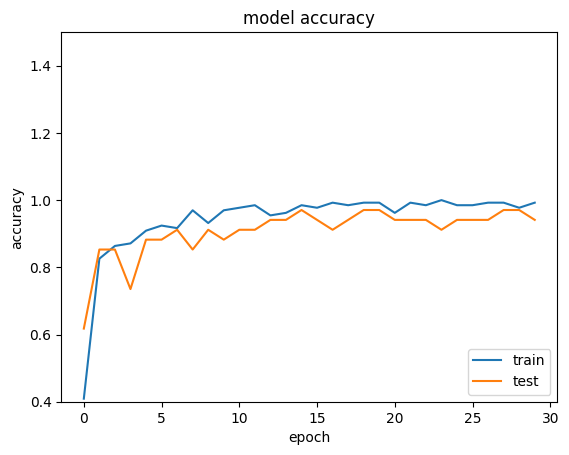

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0.4, 1.5])
plt.legend(loc='lower right')
plt.show()

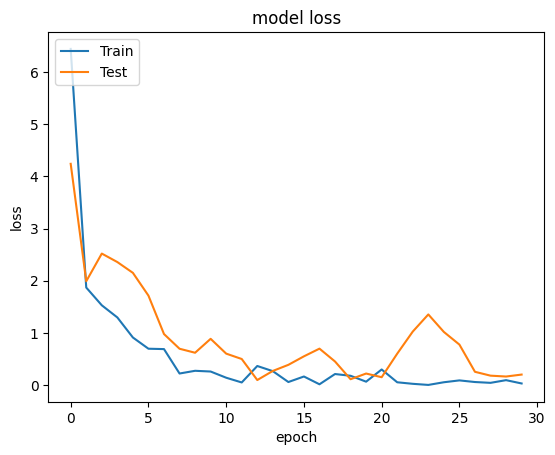

In [ ]:
#plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix using seaborn heatmap for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()


NameError: name 'model' is not defined